In [1]:
from causalgraphicalmodels import CausalGraphicalModel
import numpy as np
import pandas as pd
import random
import generate_network
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
where_data = "/home/andy/Distance_correlation_data/network_backgrounds/"


In [36]:
def read_in_data(director, model_name, pair, conditioning_size, methods):
    saving_prefix = director + model_name + "_" + "-".join(pair) + "_" + str(conditioning_size)
    data = {}
    for method in methods:
        test_stats = np.load(f"{saving_prefix}_{method}_STATS.npy")
        times = np.load(f"{saving_prefix}_{method}_TIMES.npy")
        backgrounds = np.load(f"{saving_prefix}_{method}_BACKGROUNDS.npy")
        with open(f"{saving_prefix}_{method}_SUBSETS.txt", "r") as hand:
            subsets = list(map(str.strip, hand.readlines()))
        if len(subsets) > 1 and subsets[-1] == "":
            subsets = subsets[:-1]
        data[method] = (test_stats, times, backgrounds, subsets)
    return data

def findsubsets(s, n):
    return list(map(list, itertools.combinations(s, n)))


def read_data(where_to_dir, model_name, pair, conditioning_size, method):
    data = read_in_data(where_to_dir, model_name, pair, conditioning_size, method)
    test_stats, times, backgrounds, subsets = data[method[0]]
    sorted_data = sorted(zip(test_stats, backgrounds.tolist(), times.tolist(), subsets), reverse=True)
    for i in range(len(subsets)):
        d = [sorted_data[i] for i in range(len(subsets)) if ((pair[0] not in sorted_data[i][-1]) and (pair[1] not in sorted_data[i][-1]))]
    tstats, backs, tim, subs = zip(*d)
    return tstats, backs, tim, subs


def give_time_dataframes(where_to_dir, net, parametrization, method, variables, sizes=["10", "30", "50", "150"]):
    dfs = {}
    
    for conditioning_size in range(len(variables) -1):
        times = {}
        for si in sizes:
            model_name = f"net{net}-{si}-{parametrization}"
            for pair in findsubsets(variables, 2):
                tstats, backs, tim, subs = read_data(where_to_dir, model_name, pair, conditioning_size, method)
                if f"{si}" in times.keys():
                    times[f"{si}"].extend(tim)
                else:
                    times[f"{si}"] = [*tim]
        times_df = pd.DataFrame(times)
        dfs[f"{conditioning_size}"] = times_df
    return dfs

In [81]:
#for conditioning_size in range(len(data_fr.columns) - 2):
net = 4
samples = 150
parametrization = "quadratic"
methods = ["DistCor", "DistResid", "partial_Cor"]
threshold = 5
conditioning_siz= 1
where_to_dir = where_data + f"net{net}/"

data_fr = pd.read_csv(where_data + f"net{net}/data_for_net{net}-{samples}-{parametrization}.csv", index_col=0)

fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex='col')

for i, method in enumerate(methods):
    dfs = give_time_dataframes(where_to_dir, net, parametrization, [method], data_fr.columns)
    ax = sns.boxplot(x="variable", y="value", data=dfs[f"{conditioning_siz}"].melt(), order=["10", "30", "50", "150"], ax=axes[i][0])
    plt.sca(ax)
    if i != 2:
        plt.xlabel("")
    else:
        plt.xlabel(f"Sample size", fontsize=15)
    method_name = {"DistCor": "pDistCor", "DistResid":"DistResid", "partial_Cor":"pCor"}
    plt.ylabel(f"{method_name[method]}", fontsize=15)
    if i == 0:
        plt.title(f"parametrization: {parametrization}\nconditioning size: {conditioning_siz}")

    df = pd.DataFrame({f"{conditioning_size}": dfs[f"{conditioning_size}"]["150"] for conditioning_size in range(len(data_fr.columns) - 1)})
    ax = sns.boxplot(x="variable", y = "value", data=df.melt(), ax=axes[i][1])
    plt.sca(ax)
    if i != 2:
        plt.xlabel("")
    else:
        plt.xlabel(f"Conditioning size", fontsize=15)
    plt.ylabel(f"", fontsize=15)
    if i == 0:
        plt.title(f"parametrization: {parametrization}\n sample size: {samples}")
    models = {}
    for parametrization_ in ["linear", "quadratic", "sin"]:
        dfs = give_time_dataframes(where_to_dir, net, parametrization_, [method], data_fr.columns)
        models[parametrization_] = dfs[f"{conditioning_siz}"][f"{samples}"]
    df_models = pd.DataFrame(models)
    ax = sns.boxplot(x="variable", y="value", data = df_models.melt(), ax=axes[i][2])
    plt.sca(ax)
    if i != 2:
        plt.xlabel("")
    else:
        plt.xlabel(f"Parametrization", fontsize=15)
    plt.ylabel(f"", fontsize=15)
    if i == 0:
        plt.title(f"sample size: {samples}\nconditioning size: {conditioning_siz}")
    plt.subplots_adjust(hspace=0.04, wspace=0.2, top=0.92, bottom=0.05, left=0.1, right=0.995)
    fig.text(0.01, 0.5, 'Time of execution in seconds', va='center', rotation='vertical', fontsize=15)
    plt.suptitle(f"Time comparison for Network {net}", fontsize=20, ha="center", va="center", x= 0.56, y=0.98)
#plt.show()
plt.savefig(f'Time_comparison_for_Net{net}-{samples}-{parametrization}.png', dpi=600)

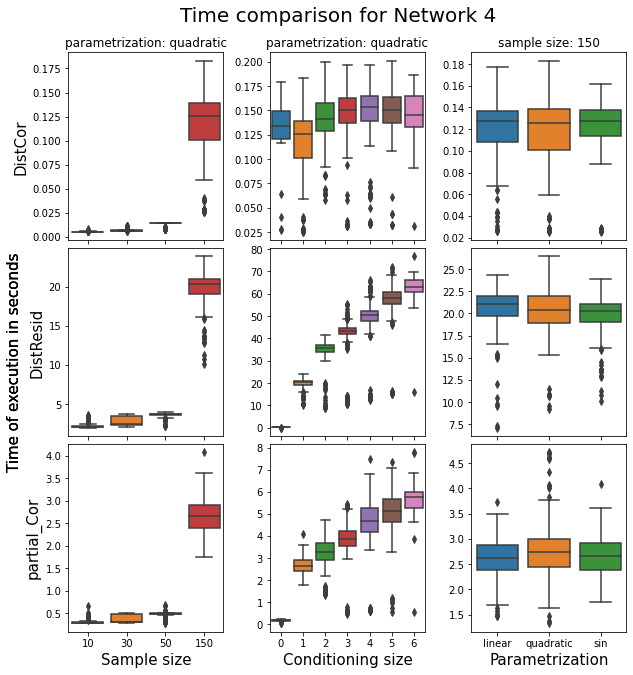

In [62]:
plt.show()